In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ray
import seaborn as sns
import math
sns.set_theme()
sns.set_style("white")
sns.set_style("ticks")
sns.set_style("ticks",{'axes.grid' : True})
import scienceplots
plt.style.use('science')
color_arr = ['#3F90DA', '#FFA90E', '#BD1F01', '#94A4A2', '#832DB6', '#A96B59', '#E76300', '#B9AC70', '#92DADD']
try:
    import cPickle as pickle
except ImportError:
    import pickle

In [4]:
def Metropolis_Function_PBC(S, E, J, B, beta, L): 
    # Place flip at some location in the domain 
    ii = (np.random.randint(L) ) % L ## 
    jj = (np.random.randint(L) ) % L

    ### First flip external field contribution
    dE = 2 * B * S[ii, jj] 
    ## Then Flip Neighbors
    for di, dj in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                dE += 2 * J * S[ii, jj] * S[(ii + di) % L, (jj + dj) % L]
    # Metropolis Transition
    if(dE <= 0):
        flip = True
    else:
        p = np.exp(-beta*dE)
        if np.random.rand() < p:
            flip = True
        else:
            flip = False

    if(flip == True):
        E += dE
        S[ii, jj] *= -1 # Flip 
    return S, E

In [ ]:
# Parallelization Function
@ray.remote
def run_simulation(L, beta, total_iters, equilibration_steps, J, B):
    S = np.random.choice([-1, 1], size=(L, L))
    E = -J * np.sum(S * (np.roll(S, 1, axis=0) + np.roll(S, 1, axis=1))) + -B * np.sum(S)
    m_arr = []
    E_arr = []
    initE = float('inf')
    stab_cond = 0
    tol_break = 1000 

    # Equilibration
    for i in range(0, equilibration_steps):
        S, E = Metropolis_Function_PBC(S, E, J, B, beta, L)
        initE = E 

    # Measurement
    for i in range(0, total_iters - equilibration_steps):
        S, E = Metropolis_Function_PBC(S, E, J, B, beta, L )
        m_arr.append(np.sum(S))
        E_arr.append(E)

        if E == initE:
            stab_cond += 1
            if stab_cond >= tol_break:
                print(f"L={L}, log10(beta)={np.log10(beta):.2f}: Energy diff reached tol after {equilibration_steps + i + 1} steps.")
                break
        else:
            stab_cond = 0
            initE = E
            
    ## Returning Densities
    return np.average(np.array(m_arr))/L**2, np.average(np.array(E_arr))/L**2

# Ray v3

In [19]:
ray.shutdown()

# Ray

2025-05-05 22:32:41,444	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 192.168.110.194:6379...
2025-05-05 22:32:41,462	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Submitting tasks for L = 10
Submitting tasks for L = 100
Submitting tasks for L = 250
Submitting tasks for L = 500
Submitting tasks for L = 1000
Retrieving results...
(autoscaler +2m33s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +2m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(raylet, ip=192.168.110.184) [2025-05-05 22:32:52,793 C 4664 28572] stream_redirection_utils.cc:94:  Check failed: result 
(raylet, ip=192.168.110.184) *** StackTrace Information ***
(raylet, ip=192.168.110.184) unknown
(raylet, ip=192.168.110.184) 


(autoscaler +3m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(raylet, ip=192.168.110.184) [2025-05-05 22:33:45,454 E 1376 1372] (raylet.exe) worker_pool.cc:581: Some workers of the worker process(4664) have not registered within the timeout. The process is dead, probably it crashed during start.
(raylet, ip=192.168.110.184) unknown [repeated 22x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


(autoscaler +3m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +4m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +4m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +5m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler 

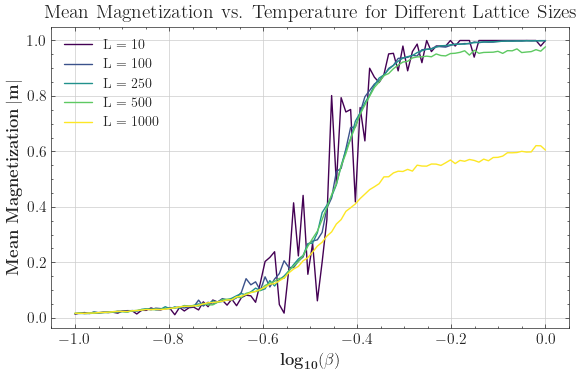

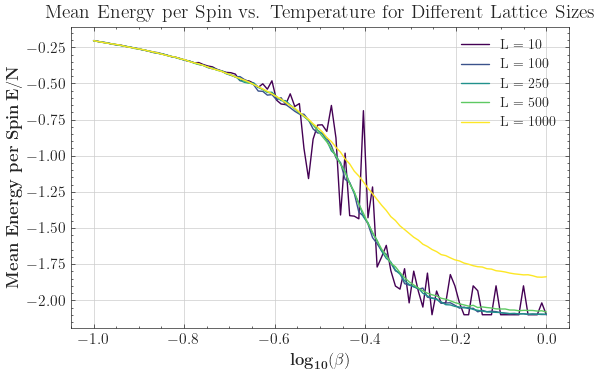

In [ ]:
# Initial Conditions
J = 1
B = 0.1
exp_arr = np.linspace(-1, 0, 10)
beta_arr = np.flip(10**exp_arr)
L_arr = [10, 100, 250, 500, 1000] 
iters_arr = [18000001, 18000001, 18000001, 18000001, 18000001, 18000001] 

ray.init()
futures = []
eq_fraq = 0.9 # Discard the first % of steps for equilibration

#### Submit Tasks to Ray
for ll, L in enumerate(L_arr):
    print(f'Submitting tasks for L = {L}')
    total_iters = iters_arr[ll]
    equilibration_steps = int(total_iters * eq_fraq)
    for beta in beta_arr:
        future = run_simulation.remote(L, beta, total_iters, equilibration_steps, J, B)
        futures.append((L, beta, future))

m_mean_data_Lvar = {L: [] for L in L_arr}
E_mean_data_Lvar = {L: [] for L in L_arr}

print("Retrieving results...")
for L, beta, future in futures:
    m_mean, E_mean = ray.get(future)
    m_mean_data_Lvar[L].append(m_mean)
    E_mean_data_Lvar[L].append(E_mean)
    print(f"L={L}, log10(beta)={np.log10(beta):.2f}, |m|={abs(m_mean):.3f}") 
ray.shutdown()

####################################### PLOTTING
plt.figure(figsize=(6, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(L_arr)))

for i, L in enumerate(sorted(L_arr)):
    plt.plot(np.log10(beta_arr), np.abs(np.array(m_mean_data_Lvar[L])), label=f'L = {L}', color=colors[i])

plt.xlabel(r'$\mathbf{\mathrm{\textbf{log}}_{10}(\beta)}$', fontsize=12)
plt.ylabel(r'$\mathbf{\mathrm{\textbf{Mean Magnetization}} \, |m|}$', fontsize=12)
plt.title('Mean Magnetization vs. Temperature for Different Lattice Sizes', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
for i, L in enumerate(sorted(L_arr)):
    plt.plot(np.log10(beta_arr), np.array(E_mean_data_Lvar[L]), label=f'L = {L}', color=colors[i])

plt.xlabel(r'$\mathbf{\mathrm{\textbf{log}}_{10}(\beta)}$', fontsize=12)
plt.ylabel(r'$\mathbf{\mathrm{\textbf{Mean Energy per Spin}} \, E/N}$', fontsize=12)
plt.title('Mean Energy per Spin vs. Temperature for Different Lattice Sizes', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

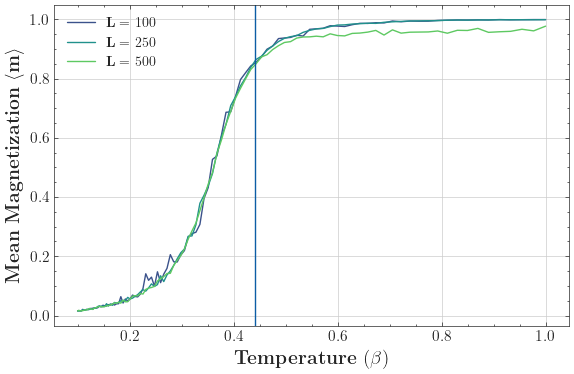

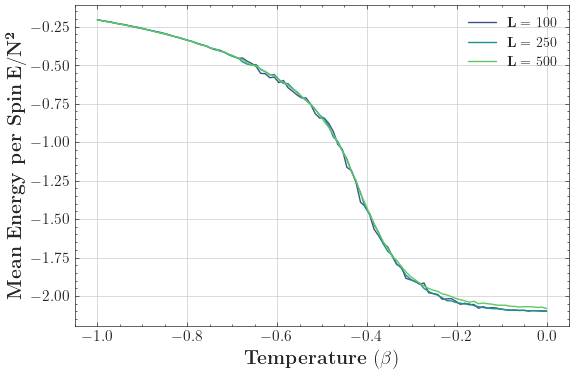

In [ ]:
plt.figure(figsize=(6, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(L_arr)))

N = 4
for i, L in enumerate(sorted(L_arr)):
    if(L != 10 and L != 1000):
        plt.plot((beta_arr), (np.array(m_mean_data_Lvar[L])), label=r'$\mathbf{L =}$' + f' {L}', color=colors[i])
plt.axvline(x = .4407)
plt.xlabel(r'\textbf{Temperature} $(\beta)$', fontsize=14)
plt.ylabel(r'$\mathbf{\mathrm{\textbf{Mean Magnetization}} \, \left<m\right>}$', fontsize=14)
# plt.title('Mean Magnetization vs. Temperature for Different Lattice Sizes', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plotting the mean energy
plt.figure(figsize=(6, 4))
for i, L in enumerate(sorted(L_arr)):
    if(L != 10 and L != 1000):
        plt.plot(np.log10(beta_arr), np.array(E_mean_data_Lvar[L]), label=r'$\mathbf{L =}$' + f' {L}', color=colors[i])

plt.xlabel(r'\textbf{Temperature} $(\beta)$', fontsize=14)
plt.ylabel(r'$\mathbf{\mathrm{\textbf{Mean Energy per Spin}} \, \mathbf{E/N^2}}$', fontsize=14)
# plt.title('Mean Energy per Spin vs. Temperature for Different Lattice Sizes', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
str1 = f'Ising-Data/m_meanfield-WFp-temp.pkl'
with open(str1, 'wb') as f:
    pickle.dump(m_mean_data_Lvar, f)
